In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from tqdm import trange
from dataclasses import dataclass
import csv

In [2]:
from module import *

In [3]:
data_rows = {
    "e":  {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1},
    "r":  {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0},
    "c":  {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1},
    "cr": {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0},
    "l":  {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1},
    "lr": {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0},
    "lc": {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1},
    "f":  {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0},
    "off":{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
}
numbers = {
    0: "f lr lr lr f",
    1: "c c c c c",
    2: "f r f l f",
    3: "f r f r f",
    4: "lr lr f r r",
    5: "f l f r f",
    6: "f l f lr f",
    7: "f r r r r",
    8: "f lr f lr f",
    9: "f lr f r f",
}
empty = np.array([[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]])

numbers_rows = {k: [data_rows[vv] for vv in v.split(" ")] for k, v in numbers.items()}

#fig, axs = plt.subplots(1, 10, figsize=(20,20))
#for ax, n in zip(axs, numbers_rows.values()):
#    ax.imshow(pd.DataFrame(n).values)

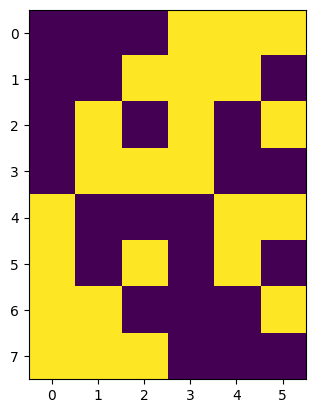

In [4]:
params_rows = {
    "tau_leak": 1, 
    "tau_inhibitory": 10,
    "tau_refractory": 10,
    "tau_ltp": 1, 
    "thres": 750,
    "ainc": 30, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": False
}
weights_rows = np.array([
    [1, 1, 1, 255, 255, 255],
    [1, 1, 255, 255, 255, 1],
    [1, 255, 1, 255, 1, 255],
    [1, 255, 255, 255, 1, 1],
    [255, 1, 1, 1, 255, 255],
    [255, 1, 255, 1, 255, 1],
    [255, 255, 1, 1, 1, 255],
    [255, 255, 255, 1, 1, 1]
])
labels_rows = [
    "e",
    "r",
    "c",
    "cr",
    "l",
    "lr",
    "lc",
    "f"
]
params_first_block = {
    "tau_leak": 50, 
    "tau_inhibitory": 30, 
    "tau_refractory": 100,
    "tau_ltp": 30 ,
    "thres": 700,
    "ainc": 20, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": True,
    "wta": True
}
plt.imshow([list(data_rows[l].values()) for l in labels_rows])

In [5]:
net = SpikeNetworkSim(inputs_l=6, dt=1)
net.new_layer(8, weights=weights_rows, labels=labels_rows, **params_rows)
net.new_layer(40, **params_first_block)
data = []
ans = []
for n in range(100):
    ans+=[np.random.randint(10) for _ in range(50)]
    data+=[x for x in numbers_rows[ans[-1]] for _ in range(10)]
    for i in range(params_first_block["tau_leak"]*2):
        ans.append(-1)
        data.append(data_rows["off"])

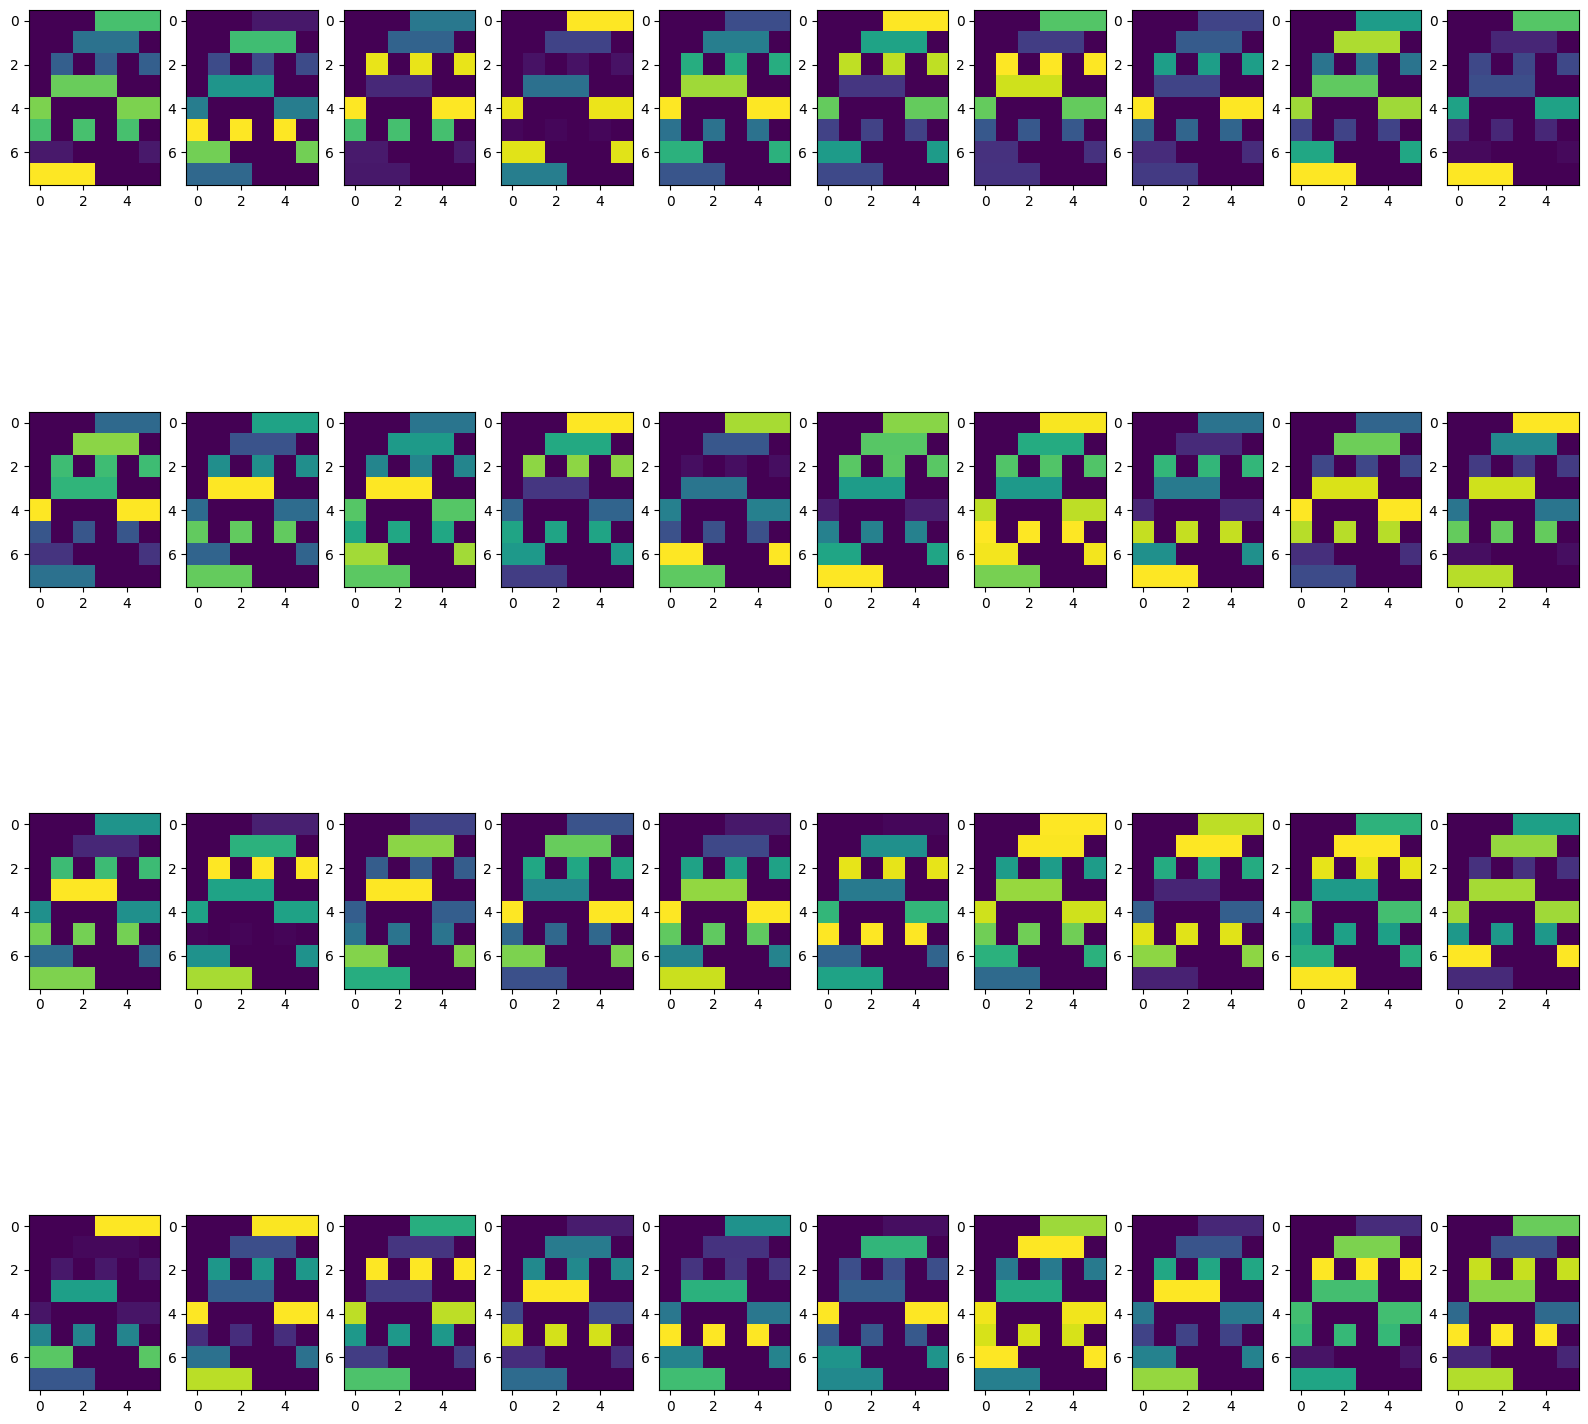

In [6]:
fig, axs = plt.subplots(4, 10, figsize=(20,20))
pre = net.nodes.join(net.layers).query("type == 'presynaptic' and layer == 1").index.tolist()
for nr, row in enumerate(axs):
    for nc, ax in enumerate(row):
        i = nr*10+nc
        w = net.weights.at[pre[i], "weights"]
        ax.imshow([np.array(list(data_rows[l].values()))*ww for l, ww in zip(labels_rows, w)])

In [7]:
%%time
out = net.feed_raw(data)

CPU times: total: 9.64 s
Wall time: 9.62 s


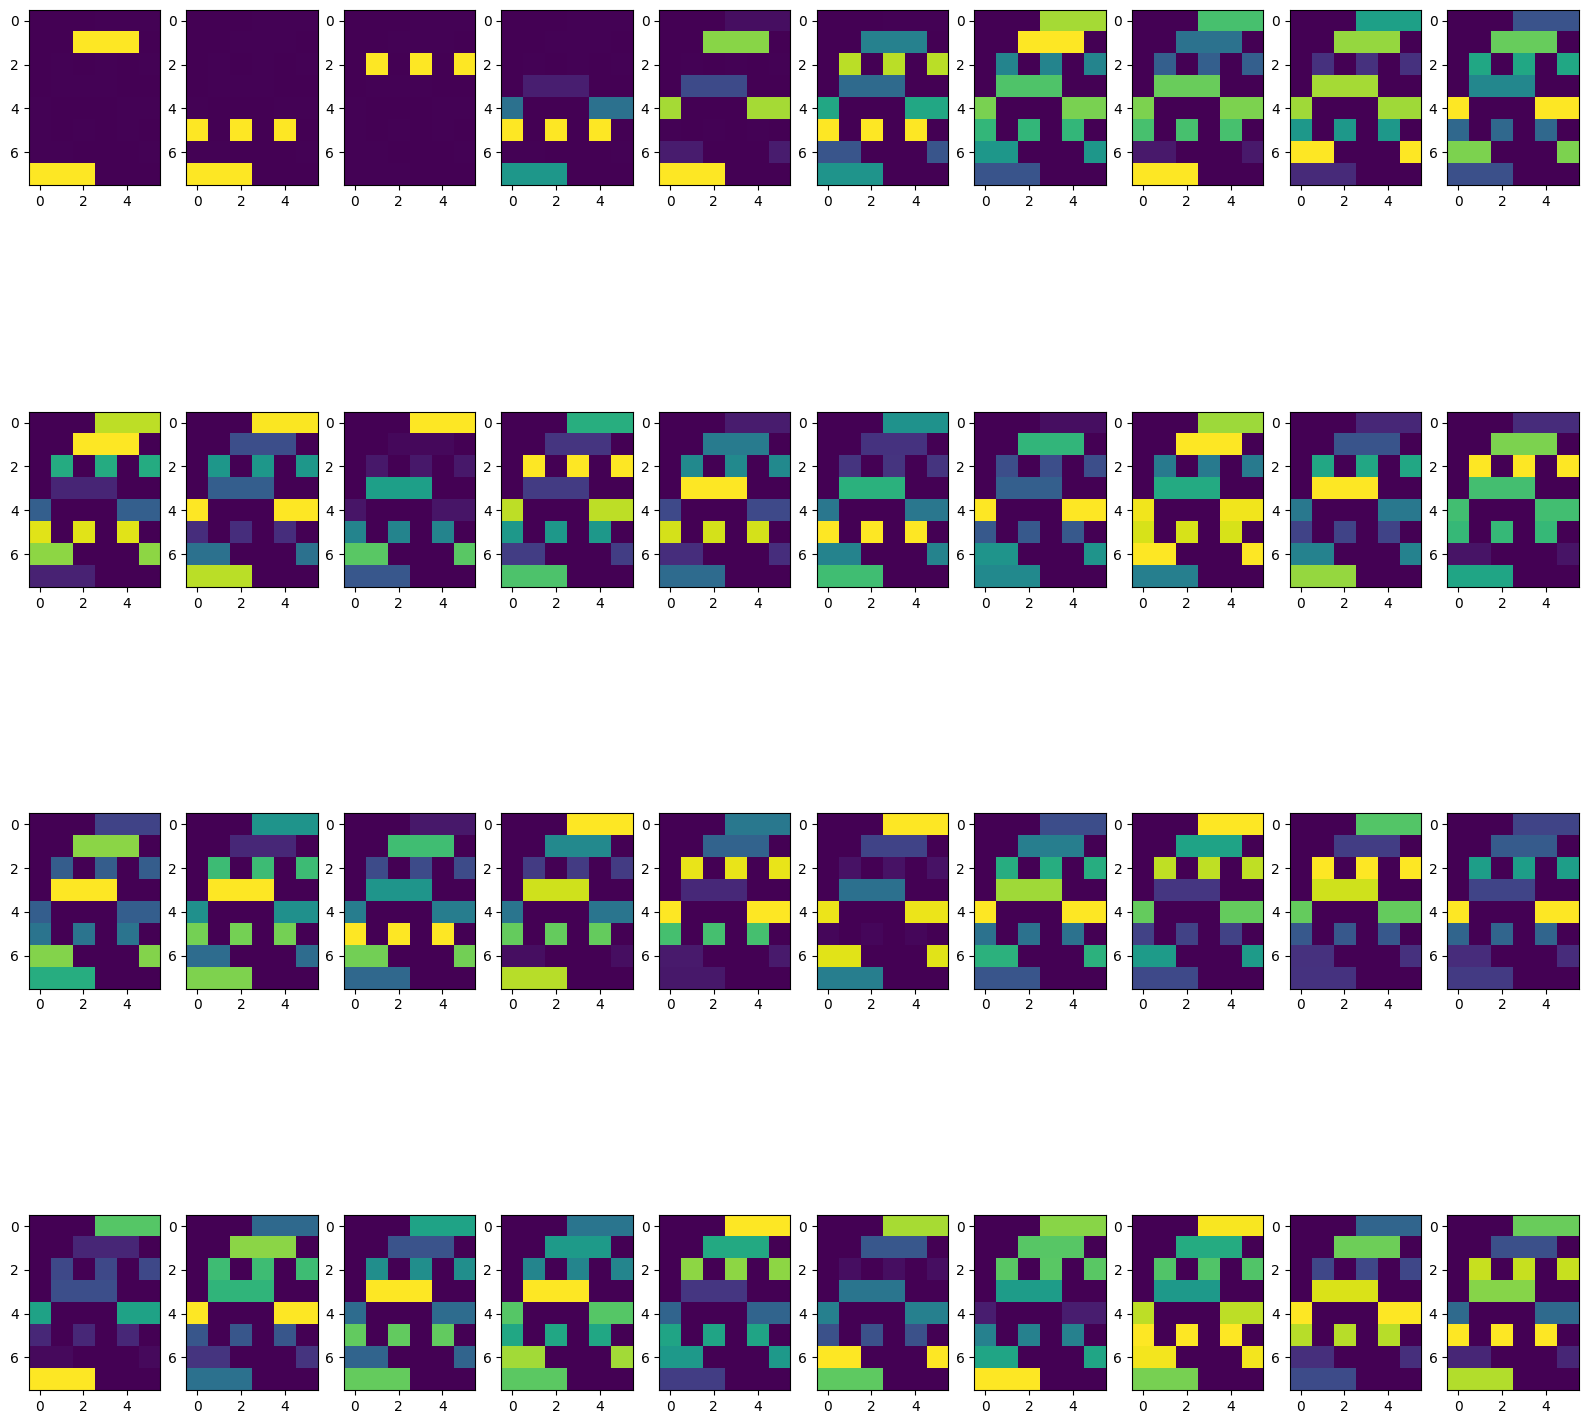

In [8]:
post = net.nodes.join(net.layers).query("type == 'postsynaptic' and layer == 1")
pre = np.array(out.loc[:, post.index].sum().sort_values(ascending=False).index.tolist())-1
fig, axs = plt.subplots(4, 10, figsize=(20,20))
for nr, row in enumerate(axs):
    for nc, ax in enumerate(row):
        i = nr*10+nc
        w = net.weights.at[pre[i], "weights"]
        ax.imshow([np.array(list(data_rows[l].values()))*ww for l, ww in zip(labels_rows, w)])

In [9]:
net.layer_params["learning"][-1] = False
params_second_block = {
    "tau_leak": 70, 
    "tau_inhibitory": 50, 
    "tau_refractory": 150,
    "tau_ltp": 50 ,
    "thres": 1000,
    "ainc": 20, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": True,
    "wta": True
}
inputs_second_block = net.layers.query("layer==0").index
net.new_layer(10, passed_inputs=inputs_second_block, **params_first_block)

In [10]:
%%time
out = net.feed_raw(data)

CPU times: total: 13.5 s
Wall time: 13.5 s


In [11]:
post2 = net.nodes.join(net.layers).query("type == 'postsynaptic' and layer == 2").index
r = net.error(ans, pos_weight=30, neg_weight=30)[post2]
r = pd.DataFrame((r.min(), r.idxmin()), index=["min", "tag"]).transpose()
r

,min,tag
235,0.9229,-1.0
238,0.9166,-1.0
241,0.9229,-1.0
244,0.9265,-1.0
247,0.9199,-1.0
250,0.9199,-1.0
253,0.9196,-1.0
256,0.9229,-1.0
259,0.9199,-1.0
262,0.9232,-1.0


In [12]:
net.error(ans)

,13,16,19,22,25,28,31,34,45,48,...,235,238,241,244,247,250,253,256,259,262
0,1.0,1.005894,0.993902,1.0,1.000000,0.998374,1.0,1.002846,1.0,1.0,...,1.003659,1.008333,1.008130,1.008333,1.001626,1.008333,1.008130,1.008130,1.006098,1.003862
1,1.0,0.999211,1.002761,1.0,0.997830,1.004931,1.0,0.994083,1.0,1.0,...,1.005720,1.003748,1.005720,1.001578,1.008087,1.005917,1.007890,1.005720,1.003748,1.005917
2,1.0,1.005686,1.002745,1.0,1.000000,0.987647,1.0,0.989804,1.0,1.0,...,1.005686,1.001569,1.005686,1.001569,1.005882,1.005882,1.003529,1.007843,1.003725,1.005882
3,1.0,1.001351,1.004826,1.0,1.002124,0.996332,1.0,0.975097,1.0,1.0,...,1.003475,1.007915,1.005598,1.001544,1.005792,1.005792,1.003475,0.999228,1.005792,1.005792
4,1.0,0.992324,0.998340,1.0,0.995436,0.996058,1.0,0.984647,1.0,1.0,...,1.006017,1.006224,1.006017,1.003942,1.001660,0.999378,1.003734,1.003734,1.003942,1.006224
5,1.0,1.006118,1.000633,1.0,1.000000,0.993671,1.0,1.012236,1.0,1.0,...,1.006118,1.006329,1.003797,1.008650,1.008650,1.006329,1.008439,1.008439,1.004008,1.006329
6,1.0,0.992355,0.989256,1.0,1.000000,0.998347,1.0,1.000620,1.0,1.0,...,1.005992,1.006198,1.008264,1.006198,0.999380,1.006198,1.003719,1.003719,1.008471,1.003926
7,1.0,0.999217,0.994129,1.0,1.002153,0.994129,1.0,1.015656,1.0,1.0,...,1.003523,0.999413,1.007828,1.008023,1.008023,1.005871,1.003523,1.007828,1.008023,1.008023
8,1.0,0.985801,0.998377,1.0,1.000000,1.009533,1.0,0.996146,1.0,1.0,...,1.005882,1.008316,0.999189,1.006085,1.008316,1.006085,1.008114,1.003651,1.008316,1.001623
9,1.0,0.993006,0.998488,1.0,0.997921,1.000567,1.0,0.990170,1.0,1.0,...,1.005482,1.007750,1.001323,1.003592,1.005671,1.003592,1.003403,1.003403,1.001512,1.003592
